## Grid Cell Specific $\delta T_L^x$ Calculations

In [3]:
import math
import xarray as xr
import numpy as np
import calendar
import pandas as pd
import datetime
import os
import cftime
import matplotlib.pyplot as plt
from scipy import stats
import sys
import seaborn as sns
from scipy.stats import linregress, pearsonr, percentileofscore, norm
sys.path.append('/home/users/chingosa/Functions/')
import CMIPFuncs as func
from multiprocessing import Pool, cpu_count
import time
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')
model = modelNames.ModelName[6]     #for whatever reason number 2 didn't work 
print(model)
# def calc(model):
tim = time.time()

periods = ['historical', 'ssp245']
variables = ['tas', 'huss', 'ps']
percentiles = [0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99]

CNRM-ESM2-1


In [ ]:
for model in modelNames.ModelName[[17]]:
    ## Grab the variables
    ds_hist, ds_ssp245 = func.dsRetrieve(variables, model, periods, gridNorm=False)
    ds_hist= ds_hist.chunk({"time": -1, 'lat':1 })
    ds_ssp245= ds_ssp245.chunk({"time": -1, 'lat':1 })
    print('here')
    # calculate q_sat
    ds_hist['q_sat'] = ((0.622*(0.6113 * np.exp(2500000/461*((1/273.15)-(1/ds_hist['tas']))))) / ((ds_hist['ps']/1000) - ((0.6113 * np.exp(2500000/461*((1/273.15)-(1/ds_hist['tas']))))*(1-0.622))))
    ds_ssp245['q_sat'] = ((0.622*(0.6113 * np.exp(2500000/461*((1/273.15)-(1/ds_ssp245['tas']))))) / ((ds_ssp245['ps']/1000) - ((0.6113 * np.exp(2500000/461*((1/273.15)-(1/ds_ssp245['tas']))))*(1-0.622))))
    
    ## Calculate MSE
    cp = 1004.6
    Lv = 2500000
    
    ds_hist['MSE'] = cp*ds_hist.tas + Lv*ds_hist.huss
    ds_ssp245['MSE'] = cp*ds_ssp245.tas + Lv*ds_ssp245.huss
    print('here')
    
    # ds_hist['MSE_MOP_land'] = func.getMeansOverPercentile_difVar(ds_hist.tas.where(ds_hist.landseamask == 1), ds_hist.MSE.where(ds_hist.landseamask == 1), percentiles, avgOut = ['time'])
    # ds_ssp245['MSE_MOP_land'] = func.getMeansOverPercentile_difVar(ds_ssp245.tas.where(ds_hist.landseamask == 1), ds_ssp245.MSE.where(ds_hist.landseamask == 1), percentiles, avgOut = ['time'])
    
    
    for var in [ 'tas','huss','q_sat', 'MSE']:
        print(var)
        hist_bin_edges = generatePDF_bins(ds_hist[var], 500)  # this function generates the bin edges for the PDF generator - takes awhile
        print('edges done')
    
        ds_hist[f'{var}_pdf'] = generatePDF(ds_hist[var], hist_bin_edges)
        ds_hist[f'{var}_pdf'].to_netcdf(f'hist_{model}_{var}11_28.nc')
        
        ssp245_bin_edges = generatePDF_bins(ds_ssp245[var], 500)  # this function generates the bin edges for the PDF generator - takes awhile
        print('edges done')
        
        ds_ssp245[f'{var}_pdf'] = generatePDF(ds_ssp245[var], ssp245_bin_edges)
        ds_ssp245[f'{var}_pdf'].to_netcdf(f'ds_ssp245_{model}_{var}11_28.nc')


In [5]:
###----------------------------------------------------------------------------------------------------------------------------------###
#     
###----------------------------------------------------------------------------------------------------------------------------------### 

for model in list(modelNames.ModelName[[17]]):
    
    ds_hist, ds_ssp245 = func.dsRetrieve(variables, model, periods, gridNorm=False)
    ds_hist= ds_hist.chunk({"time": -1, 'lat':1 })
    ds_ssp245= ds_ssp245.chunk({"time": -1, 'lat':1 })

    # calculate q_sat
    ds_hist['q_sat'] = ((0.622*(0.6113 * np.exp(2500000/461*((1/273.15)-(1/ds_hist['tas']))))) / ((ds_hist['ps']/1000) - ((0.6113 * np.exp(2500000/461*((1/273.15)-(1/ds_hist['tas']))))*(1-0.622))))
    ds_ssp245['q_sat'] = ((0.622*(0.6113 * np.exp(2500000/461*((1/273.15)-(1/ds_ssp245['tas']))))) / ((ds_ssp245['ps']/1000) - ((0.6113 * np.exp(2500000/461*((1/273.15)-(1/ds_ssp245['tas']))))*(1-0.622))))
    
    ## Calculate MSE
    cp = 1004.6
    Lv = 2500000
    
    ds_hist['MSE'] = cp*ds_hist.tas + Lv*ds_hist.huss
    ds_ssp245['MSE'] = cp*ds_ssp245.tas + Lv*ds_ssp245.huss
    
    #pull MSE_pdf in
    var = 'MSE'
    ds_hist['MSE_pdf'] = xr.open_dataset(f'hist_{model}_{var}11_28.nc').MSE_pdf
    ds_ssp245['MSE_pdf'] = xr.open_dataset(f'ds_ssp245_{model}_{var}11_28.nc').MSE_pdf
    
    ### calculate the mean of variables on days where the temperature exceeds a certian percentile 
    for var in ['tas','huss', 'q_sat', 'MSE']:
        ds_hist[f'{var}_MOP_land'] = func.getMeansOverPercentile_difVar(ds_hist.tas.where(ds_hist.landseamask == 1), ds_hist[var].where(ds_hist.landseamask == 1), percentiles, avgOut = ['time'])
        ds_ssp245[f'{var}_MOP_land'] = func.getMeansOverPercentile_difVar(ds_ssp245.tas.where(ds_ssp245.landseamask == 1), ds_ssp245[var].where(ds_hist.landseamask == 1), percentiles, avgOut = ['time'])
    
    ### we then estimate the MSE percentile corresponding to the mean MSE for days where the temperature exceeds a certian percentile 
    # we do this for both ds_ssp245 and ds_historical - however we will only use the ds_hist['MSE_land_px'] values to calculate the ocean variables 
    # this is becasue it sas that px is defined as the moist static energy percentile over land corresponding to the average MSE of days exceeding the xth percentile of temperature in the historic simulation
    ds_hist['MSE_land_px']  = estimatePx(ds_hist.MSE_pdf, ds_hist.MSE_MOP_land)
    ds_ssp245['MSE_land_px']  = estimatePx(ds_ssp245.MSE_pdf, ds_ssp245.MSE_MOP_land)   # we keep this around for the dPx calculation
    
    # For each variable we read in a preprocessed pdf of that variable 
    for var in ['tas', 'q_sat', 'huss']:
        ds_hist[f'{var}_pdf'] = xr.open_dataset(f'hist_{model}_{var}11_28.nc')[f'{var}_pdf']
        ds_ssp245[f'{var}_pdf'] = xr.open_dataset(f'ds_ssp245_{model}_{var}11_28.nc')[f'{var}_pdf']
    
        # And calculate the value of that variable at a certian percentile specified by MSE_land_px in the historical simulation 
        # here we are looking for ocean values with the issue that thus far MSE_land_px is only defined over land 
        # we deal with this by getting the average value by lon for MSE_land_px
        ds_hist[f'{var}_ocean_px'] = ValuefromPx(ds_hist[f'{var}_pdf'].where(ds_hist.landseamask == 0), ds_hist.MSE_land_px.mean('lon'))
        ds_ssp245[f'{var}_ocean_px'] = ValuefromPx(ds_ssp245[f'{var}_pdf'].where(ds_ssp245.landseamask == 0), ds_hist.MSE_land_px.mean('lon'))
    
    
    
    ds = xr.Dataset()
    
    ds['landseamask'] = ds_hist.landseamask
    ds['latWeight'] = ds_hist.latWeight
    ds['landFracWeight'] = ds_hist.landFracWeight
    ds['d_q_sat_land'] = (ds_ssp245.q_sat_MOP_land - ds_hist.q_sat_MOP_land)
    ds['d_q_sat_ocean'] = (ds_ssp245.q_sat_ocean_px - ds_hist.q_sat_ocean_px).weighted(ds_hist.oceanFracWeight * ds_hist.latWeight).mean('lon')
    
    ds['d_tas_land'] = (ds_ssp245.tas_MOP_land - ds_hist.tas_MOP_land)
    ds['d_tas_ocean'] = (ds_ssp245.tas_ocean_px - ds_hist.tas_ocean_px).weighted(ds_hist.oceanFracWeight * ds_hist.latWeight).mean('lon')
    
    ds['alpha_L'] = ((ds.d_q_sat_land/ds_hist.q_sat_MOP_land) / ds.d_tas_land)
    
    ds['alpha_O'] = ((ds.d_q_sat_ocean/ds_hist.q_sat_ocean_px.weighted(ds_hist.oceanFracWeight * ds_hist.latWeight).mean('lon')) / ds.d_tas_ocean)
    
    ds['gamma_top'] = (cp + (Lv*ds.alpha_O* ds_hist.huss_ocean_px.weighted(ds_hist.oceanFracWeight * ds_hist.latWeight).mean('lon')))
    
    ds['gamma_bottom'] = (cp + (Lv*ds.alpha_L* ds_hist.huss_MOP_land))
    
    ds['gamma'] = ds.gamma_top/ds.gamma_bottom 
    
    ds['d_tas_land_predict'] = (ds.gamma*ds.d_tas_ocean)
    ds['d_px'] = (ds_ssp245.MSE_land_px - ds_hist.MSE_land_px)
    ds['dfracland_ocean'] = ds['d_tas_land']/ds['d_tas_ocean']
    ds = ds.drop_vars(['d_q_sat_land', 'd_q_sat_ocean', 'alpha_L', 'alpha_O', 'gamma_top', 'gamma_bottom'])
    ds = ds.expand_dims(model = [model])
    normGrid = xr.open_dataset('/badc/cmip6/data/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp245/r1i1p1f1/fx/sftlf/gr1/latest/sftlf_fx_GFDL-CM4_ssp245_r1i1p1f1_gr1.nc').sftlf.sel(lat=slice(-20,20))
    ds = ds.interp_like(normGrid, kwargs={"fill_value": "extrapolate"})
    ds.to_netcdf(f'{model}_11_22.nc')
    
    del ds, ds_hist, ds_ssp245


/opt/jaspy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


In [6]:
normGrid.sel(lat=slice(-20,20))

<xarray.DataArray 'sftlf' (lat: 40, lon: 288)> Size: 46kB
[11520 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 320B -19.5 -18.5 -17.5 -16.5 ... 16.5 17.5 18.5 19.5
  * lon      (lon) float64 2kB 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
Attributes:
    long_name:        Land Area Fraction
    units:            %
    cell_methods:     area: mean
    cell_measures:    area: areacella
    ocean_fillvalue:  0.0
    standard_name:    land_area_fraction
    interp_method:    conserve_order1
    original_name:    sftlf

### Lunch time retry

In [6]:
# 27 for one value of percentile, 29 for two - so likely not casuing the issues
# Adding the regridding took it out to 40 seconds - so linearly interpolating across 3 dimensions donesnt take too long
# quadrupling the number of grid points only took 37 seconds
# doing the whole range didn't really affect it either lol

nan


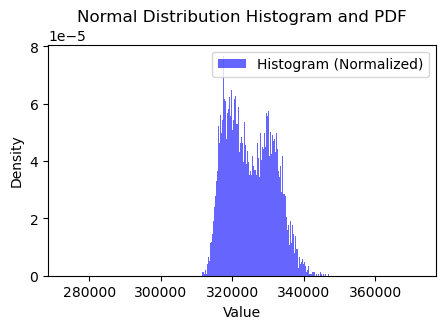

In [65]:
# mean = 0  # Mean of the distribution
# std_dev = 1  # Standard deviation
# data = ds_hist.MSE.isel({'lat':1, 'lon': 1}).values.flatten()

counts, bin_edges = np.histogram(data, bins=bin_edges, density=True)

# Step 3: Generate a probability density curve
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers
# pdf = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((bin_centers - mean) / std_dev) ** 2)

# Step 1: Define the value for which to calculate the percentile
score = 1.2  # Example score

# Step 2: Compute the percentile using the CDF of the normal distribution
percentile = percentileofscore(data, 1.2)
print(percentile)

plt.figure(figsize=(5, 3))
plt.bar(bin_centers, counts, width = bin_width, alpha=0.6, color='blue', label='Histogram (Normalized)')
# plt.plot(bin_centers, pdf, color='red', label='Probability Density Function')
plt.title("Normal Distribution Histogram and PDF")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

In [4]:
def generatePDF_bins(da, nBins):
    '''np.histogram_bin_edges except it filters out nanvalues first bc that sort of breaks it I guess'''
    return np.histogram_bin_edges(da.values.flatten()[~np.isnan(da.values.flatten())], bins=nBins)

def generatePDF(da, bin_edges):
    # Compute bin centers
    name = da.name
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Define the function to compute histogram with density normalization
    def compute_histogram(data):
        if data.size == 0:
            return np.zeros(len(bin_edges) - 1)
        hist, _ = np.histogram(data, bins=bin_edges, density=True)
        return hist

    # Apply the histogram function along the 'time' dimension
    da_pdf = xr.apply_ufunc(
                            compute_histogram,
                            da,
                            input_core_dims=[['time']],
                            output_core_dims=[[f"bins_{name}"]],
                            vectorize=True,
                            dask='parallelized',
                            dask_gufunc_kwargs={'output_sizes': {f"bins_{name}": len(bin_edges)-1},
                                               'allow_rechunk': True},
                            output_dtypes=[float]
                            )

    # Assign coordinates and rename for clarity
    da_pdf = da_pdf.assign_coords({f"bins_{name}": bin_centers})
    da_pdf = da_pdf.rename(f'{da.name}_pdf')

    return da_pdf

def estimateP(score, bin_centers, pdf, binWidth):
    '''
    Description:
    this function is a helper function to estimatePx - it estimates a value of percentile for a given score of a variable from a pdf of that variable using linear interpolation across a cdf
    Parameters
    ----------
    score - the value you want to estimate
    bin_centers - the center of each bin the pdf is applied over
    pdf - the probability density function describing the distribition of a variable
    binwidth - the width of bins idk

    returns
    -------
    percentile_score - a value 0-100 of the estimated percentile that the prodived score corresponds to

    '''
     
    pdf = pdf.flatten()
    cdf_approx = np.cumsum(pdf * binWidth)  # Cumulative sum to approximate the CDF
    
    # # Find the index of the bin closest to the score
    # index = np.argmin(np.abs(bin_centers - score))
    
    # # Step 2: Identify the two bins to either side for interpolation
    # if bin_centers[index] < score:
    #     left_idx, right_idx = index, index + 1
    # else:
    #     left_idx, right_idx = index - 1, index
    
    # # Ensure indices are within bounds
    # left_idx = max(left_idx, 0)
    # right_idx = min(right_idx, len(bin_centers) - 1)
    
    # # Step 3: Linearly interpolate the percentile
    # x_left, x_right = bin_centers[left_idx], bin_centers[right_idx]
    # y_left, y_right = cdf_approx[left_idx], cdf_approx[right_idx]
    
    # # Perform linear interpolation
    # percentile_score = y_left + (y_right - y_left) * ((score - x_left) / (x_right - x_left))
    percentile_score = np.interp(score, bin_centers, cdf_approx)
    return percentile_score*100  # Return as a numpy array
    

def estimatePx(da_pdf, da_score):
    '''
    Description:
    Estimates the percentile of a given score given pdfs and scores
    Parameters
    ----------
    da_pdf - dataarray with a probability denisity function running along axis bins_name
    da_score - dataarray with scores of name variable that you want to get the estimated percentiles of
    returns
    -------
    da_px - dataarray with same dimensions as da_score
    '''
     
    name = da_pdf.name[:-4]
    bin_centers= da_pdf[f'bins_{name}'].values
    binWidth = bin_centers[1]-bin_centers[0]
    
    da_px = xr.apply_ufunc(
        lambda x, y: estimateP(y, bin_centers, x, binWidth), 
        da_pdf,  
        da_score,  
        input_core_dims=[[f"bins_{name}"], []], 
        output_core_dims=[[]],  
        vectorize=True,  
        dask="parallelized",  
        dask_gufunc_kwargs={'allow_rechunk': True},  
        output_dtypes=[float]  
    )
    return da_px

def valueAtPx(da_values, da_px):
    '''
    Description:
    applies np.nanpercentile across every gridbox of lat and lon minimizing across time

    Parameters
    ----------
    da_values - datarray with lat lon time specifying the raw data for some value
    da_px - dataarray wit lat, lon, and MOP specifying what percentile values it wants from the values

    Note this takes a very long time to work and is ram heavy - not currently in use - swapped out for interpolation from pdf instead
    
    returns
    -------
    da: data array with same output dimensions as da_px (input) - the value of da_values at xth percentile


    '''
     
    da = xr.apply_ufunc(lambda x, y: np.nanpercentile(x,y),
                  da_values, 
                  da_px,
                  input_core_dims=[['time'],[]],
                  dask_gufunc_kwargs={
                      'allow_rechunk': True},
                  vectorize=True,
                  dask="parallelized",
                  output_dtypes=[float]
                 )
    return da

def estimateValueFromPDF(percentile, bin_centers, pdf, binWidth):
    '''
    Description:
    Helper function for ValuefromPx() - used to interpolate the value from a percentile using a cumulative distribution function and a percentile
    Note that percentile is provided in 0-100 percentile space and devided to work with a 0-1 pdf
    Parameters
    ----------
    percentile: percentile - 0-100 
    bin_centers - 1D array - essentially the values from bins_name
    pdf - density at bin centered at bin_centers
    binWidth - width of bin - single value (maybe make list support later)    
    
    returns
    -------
    float - of interpolated value for a percentile

    '''
    pdf = pdf.flatten()
    cdf_approx = np.cumsum(pdf * binWidth)  # Cumulative sum to approximate the CDF
    return np.interp(percentile/100, cdf_approx, bin_centers)
    
def ValuefromPx(da_pdf, da_px):
    '''
    Description:
    This function estimates the value at xth percentile

    Parameters
    ----------
    da_pdf: dataarray with ['lat', 'lon', f'bins_{name}'] - bins_name are the bincenters of the probability density function
            the sum of the values aligned along bins_name must equal one

    da_px: dataarray with ['lat', 'lon', 'MOP'] - specifies the percentile in 0-100 space (devision happens within estimateValueFromPDF
    
    returns
    -------
    da_px: data array with same output dimensions as da_px (input) - its an estimate from the pdf of the value of var at xth percentile

    '''
     
    name = da_pdf.name[:-4]
    bin_centers= da_pdf[f'bins_{name}'].values
    binWidth = bin_centers[1]-bin_centers[0]
    
    da_px = xr.apply_ufunc(
        lambda x, y: estimateValueFromPDF(y, bin_centers, x, binWidth), 
        da_pdf,  
        da_px,  
        input_core_dims=[[f"bins_{name}"], ["MOP"]], 
        output_core_dims=[["MOP"]],  
        vectorize=True,  
        dask="parallelized",  
        dask_gufunc_kwargs={'allow_rechunk': True},  
        output_dtypes=[float]  
    )
    return da_px

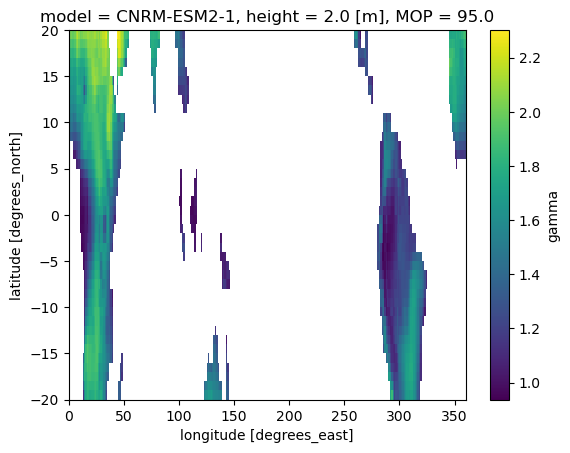

In [39]:
ds = xr.open_dataset('CNRM-ESM2-1_11_22.nc')
ds.gamma.sel({'MOP':95, 'model':'CNRM-ESM2-1'}).plot()
# ds.close()

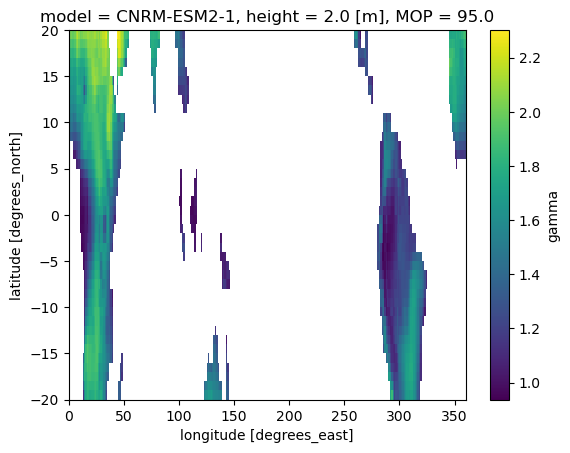

In [37]:
ds.gamma.sel(MOP = 95).plot()

---
### Tring to rework MOP calculations to be more effecient

In [2]:
variables = ['tas']
for model in modelNames.ModelName[]:
    ds_hist, ds_ssp245 = func.dsRetrieve(variables, model, ['historical'], gridNorm=False)
    print(f'{model}: {ds_hist.tas.dims}; {ds_hist.tas.shape}')

ACCESS-CM2: ('time', 'lat', 'lon'); (7670, 32, 192)
ACCESS-ESM1-5: ('time', 'lat', 'lon'); (7670, 33, 192)
BCC-CSM2-MR: ('time', 'lat', 'lon'); (7664, 36, 320)
CanESM5: ('time', 'lat', 'lon'); (7664, 14, 128)


/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/jaspy/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values

CESM2-WACCM: ('time', 'lat', 'lon'); (7665, 42, 288)
CNRM-CM6-1: ('time', 'lat', 'lon'); (7670, 28, 256)
CNRM-ESM2-1: ('time', 'lat', 'lon'); (7670, 28, 256)
GFDL-CM4: ('time', 'lat', 'lon'); (7664, 40, 288)
GFDL-ESM4: ('time', 'lat', 'lon'); (7664, 40, 288)
HadGEM3-GC31-LL: ('time', 'lat', 'lon'); (7559, 32, 192)
INM-CM4-8: ('time', 'lat', 'lon'); (7664, 26, 180)
INM-CM5-0: ('time', 'lat', 'lon'); (7664, 26, 180)
KACE-1-0-G: ('time', 'lat', 'lon'); (7559, 32, 192)
MIROC-ES2L: ('time', 'lat', 'lon'); (7670, 14, 128)
MPI-ESM1-2-LR: ('time', 'lat', 'lon'); (7670, 22, 192)
MRI-ESM2-0: ('time', 'lat', 'lon'); (7670, 36, 320)
NorESM2-LM: ('time', 'lat', 'lon'); (7664, 22, 144)
UKESM1-0-LL: ('time', 'lat', 'lon'); (7559, 32, 192)


In [11]:
print(f'{model}: {ds_hist.tas.dims}; {ds_hist.tas.shape}')

CNRM-ESM2-1: ('time', 'lat', 'lon'); (7670, 28, 256)


In [5]:

ds_hist= ds_hist.chunk({"time": -1, 'lon':1 })
ds_hist

<xarray.Dataset> Size: 213MB
Dimensions:          (time: 7559, bnds: 2, lat: 32, lon: 192)
Coordinates:
  * time             (time) object 60kB 1980-01-01 12:00:00 ... 2000-12-29 12...
  * lat              (lat) float64 256B -19.38 -18.12 -16.88 ... 18.12 19.38
  * lon              (lon) float64 2kB 0.9375 2.812 4.688 ... 355.3 357.2 359.1
    height           float64 8B 1.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds        (time, bnds) object 121kB dask.array<chunksize=(7559, 2), meta=np.ndarray>
    lat_bnds         (time, lat, bnds) float64 4MB dask.array<chunksize=(7559, 1, 2), meta=np.ndarray>
    lon_bnds         (time, lon, bnds) float64 23MB dask.array<chunksize=(7559, 1, 2), meta=np.ndarray>
    tas              (time, lat, lon) float32 186MB dask.array<chunksize=(7559, 1, 1), meta=np.ndarray>
    landseamask      (lat, lon) float64 49kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    latWeight        (lat) float64 256B dask.array<chunksize=(1,), meta=np.ndarray>
    landFracWeight   (lat) float64 256B dask.array<chunksize=(1,), meta=np.ndarray>
    oceanFracWeight  (lat) float64 256B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  144000.0
    creation_date:          2019-06-24T15:18:36Z
    ...                     ...
    title:                  UKESM1-0-LL output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/20896b0d-3a14-4a74-b314-600a07e8fe55

In [18]:

def getMeansOverPercentile_difVar(da, da_con, percentiles, avgOut=['time'], mask=None, thresholds=None):
    "
    # Apply the mask if provided
    if mask is not None:
        da = da.where(mask)
        da_con = da_con.where(mask)

    # Compute thresholds if not provided
    if thresholds is None:
        quantiles = np.array(percentiles) / 100
        thresholds = da.quantile(quantiles, dim=avgOut, skipna=True)
    
    # Compute means over percentiles
    means = xr.concat(
        [
            da_con.where(da > thresholds.sel(quantile=q)).mean(dim=avgOut)
            for q in thresholds.coords["quantile"].values
        ],
        dim="MOP"
    )
    
    # Assign the percentile values as a coordinate for clarity
    means = means.assign_coords(MOP=percentiles)
    return means

# var = 'huss'
# ds_hist[f'{var}_MOP_land'] = getMeansOverPercentile_difVar(ds_hist.tas.where(ds_hist.landseamask == 1), ds_hist[var].where(ds_hist.landseamask == 1), percentiles, avgOut = ['time'])


In [20]:
quantiles = np.array(percentiles) / 100
thresholds_hist_tas = ds_hist.tas.where(ds_hist.landseamask == 1).quantile(quantiles, dim="time", skipna=True)

# Loop over variables and reuse thresholds
for var in ['tas', 'huss']:
    ds_hist[f'{var}_MOP_land'] = getMeansOverPercentile_difVar(
        ds_hist.tas, 
        ds_hist[var], 
        percentiles, 
        avgOut=['time'], 
        mask=ds_hist.landseamask == 1, 
        thresholds=thresholds_hist_tas
    )